In [10]:
import pandas as pd
import pymupdf
import time
from PIL import Image
import io
import pickle
import pypdfium2 as pdfium

import os, sys
sys.path.append(os.path.abspath("../"))
from src.helper import show_clustered_image, calculate_cmyk_percentage

In [11]:
start = time.time()
model = pickle.load(open("../models/random_forest_classifier_c_m_y_k_sum_5_dpi_small.pkl", 'rb'))

print(f"Finish loading model in {time.time() - start} seconds")
model

Finish loading model in 0.008150100708007812 seconds


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scale', RobustScaler(),
                                                  ['c', 'm', 'y', 'k',
                                                   'sum'])])),
                ('classification',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy',
                                        max_features='log2'))])

In [14]:
# PYMUPDF
a = None
img = None
total = 0

two_d_array = []

start = time.time()
doc = pymupdf.open("../datasets/statistik-indonesia-2024-combined.pdf")


for page in doc:
    a = page.get_pixmap(dpi=1)
    img = Image.open(io.BytesIO(a.tobytes()))
    c, m, y, k = calculate_cmyk_percentage(img)
    cmy = c + m + y
    sum_ = cmy + k
    two_d_array.append([c,m,y,k,sum_])

print(f"Finish at {time.time() - start} seconds")

df = pd.DataFrame(two_d_array, columns=['c', 'm', 'y', 'k', 'sum'], index=range(0,len(two_d_array)))


result = model.predict(df)
print(pd.Series(result).value_counts())
print(sum(result))

Finish at 6.932206153869629 seconds
1000    377
500     217
1500    161
750     110
2000     19
Name: count, dtype: int64
847500


In [13]:
# PDFIUM
a = None
img = None
total = 0

two_d_array = []

start = time.time()
doc = pdfium.PdfDocument("../datasets/statistik-indonesia-2024-combined.pdf")


for page in doc:
    bitmap = page.render(1/72 * 5)
    img = bitmap.to_pil() 
    c, m, y, k = calculate_cmyk_percentage(img)
    cmy = c + m + y
    sum_ = cmy + k
    two_d_array.append([c,m,y,k,sum_])
    # df_inference = pd.DataFrame([[cmy, k, sum_]], columns=['cmy', 'k', 'sum'], index=[0])
    # res = grid_rfc.predict(df_inference)[0]
    # total += res

print(f"Finish at {time.time() - start} seconds")

df = pd.DataFrame(two_d_array, columns=['c', 'm', 'y', 'k', 'sum'], index=range(0,len(two_d_array)))

result = model.predict(df)
print(pd.Series(result).value_counts())
print(sum(result))

Finish at 8.324200868606567 seconds
1500    375
1000    257
500     180
750      53
2000     19
Name: count, dtype: int64
987250


In [ ]:
df = pd.DataFrame(two_d_array, columns=['c', 'm', 'y', 'k', 'sum'], index=range(0,len(two_d_array)))
df

In [15]:
df['cmy'] = df['c'] + df['m'] + df['y']
start = time.time()
print(sum(model.predict(df)))

print(f"Predicted in {time.time() - start} seconds")

792000
Predicted in 0.017628908157348633 seconds


In [20]:
import pdf2image

In [22]:
start = time.time()
pdf = pdf2image.convert_from_path("../datasets/statistik-indonesia-2024-combined.pdf", dpi=5)
print(time.time() - start)
pdf

13.34173583984375


[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x66>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x63>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=43x65>,
 <PIL.Pp

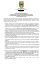

In [23]:
pdf[0]

In [30]:
df = pd.read_csv("../datasets/cmyk_by_dpi_and_render_options.csv")
df = df[(df['dpi'] == 5) & (df['options'] == 'default')].reset_index(drop=True)
df

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff,options
0,0.036831,1,5,0.16,0.19,0.52,8.93,9.80,-1.11,1.11,default
1,0.156529,2,5,0.56,0.51,0.00,4.35,5.42,0.60,0.60,default
2,0.017131,3,5,0.00,0.00,0.00,65.50,65.50,-55.29,55.29,default
3,0.009017,4,5,0.00,0.00,0.00,75.99,75.99,-64.96,64.96,default
4,0.009348,5,5,0.00,0.00,0.00,75.99,75.99,-64.81,64.81,default
...,...,...,...,...,...,...,...,...,...,...,...
879,0.023905,880,5,0.00,0.00,0.00,6.24,6.24,-0.52,0.52,default
880,0.032836,881,5,2.55,11.07,11.06,15.09,39.77,-5.30,5.30,default
881,0.003468,882,5,0.81,1.20,1.84,1.35,5.20,-0.09,0.09,default
882,0.016195,883,5,4.67,27.89,29.58,16.01,78.15,-7.01,7.01,default


In [31]:
import pickle

model = pickle.load(open("../models/random_forest_classifier_c_m_y_k_sum_5_dpi_small.pkl", 'rb'))
model

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scale', RobustScaler(),
                                                  ['c', 'm', 'y', 'k',
                                                   'sum'])])),
                ('classification',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy',
                                        max_features='log2'))])

In [32]:
result = model.predict(df)

In [38]:
pd.Series(result).value_counts()

1500    375
1000    257
500     180
750      53
2000     19
Name: count, dtype: int64

In [40]:
sum(result)

987250

In [43]:
result = model.predict(df)
pd.Series(result).value_counts()

1000    377
500     217
1500    161
750     110
2000     19
Name: count, dtype: int64